# SymPy の応用例：二重振り子
SymPyとNumPyの組み合わせが強力であることを示す例として、二重振り子を数値計算で解くということを試みます。  
もちろん普通に解いてもしょうがないので、座標設定からラグランジアン、そして運動方程式をシンボリックに求め、最後に数値計算することにします。

[解析力学(Wikipedia)](https://ja.wikipedia.org/wiki/%E8%A7%A3%E6%9E%90%E5%8A%9B%E5%AD%A6) の知識が必要ですが、コメントで補足しながら進めます。

## モデル設定
水平にx軸、鉛直上向きにy軸があり、y軸負方向に重力がかかっています。  
また、原点から長さ$r_1$の棒の先に１つ目の質点がついていて、そこから長さ$r_2$の棒で２つ目の質点がつながっているとします。  
それぞれの棒がy軸とのなす角をそれぞれ$\theta_1, \theta_2$とします。

二つの質点の質量をそれぞれ $m_1, m_2$ とします。

<img src="double_pendulum_model.png" width=500>

## ゴールの確認

二重振り子の運動方程式は、最終的には時刻 $t$ についての連立2階線形微分方程式になります。

今回は、極座標表現を用いるので、質点の（角度の）加速度 $\ddot{\theta_1}, \ddot{\theta_2}$についての微分方程式が得られれば、数値計算することができます。

$$\ddot{\theta_1} = f_1 (\theta_1, \dot{\theta_1}, \theta_2, \dot{\theta_2})$$
$$\ddot{\theta_2} = f_2 (\theta_1, \dot{\theta_1}, \theta_2, \dot{\theta_2})$$

$f_1, f_2$ の具体的な形を求めにいきましょう。

In [1]:
# 準備
import sympy as sy
sy.init_printing()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

時刻を表す $t$ や、質点ごとの棒の長さを表す $r_1, r_2$ 、 質量を表す $m_1, m_2$ 、重力加速度を表す $g$ を定義します。

$\theta_1, \theta_2$ は $t$ の関数 $\theta_1(t), \theta_2(t)$として扱います。

$\dot{\theta_1} \dot{\theta_2}$ は $\theta_1, \theta_2$ の時間微分です。


In [2]:
# 変数と関数を定義
t = sy.Symbol("t", real=True)
r1, r2, m1, m2, g = sy.symbols(r"r_1 r_2 m_1 m_2 g", positive=True)
theta1 = sy.Function(r"\theta_1")(t)
theta2 = sy.Function(r"\theta_2")(t)
theta1_dot, theta2_dot = sy.symbols(r"\dot{\theta_1} \dot{\theta_2}")

質点1 は原点を中心とする半径 $r_1$ の円上を動きます。

y 軸とのなす角である $\theta_1$ を使うことで、 $(x_1, y_1)$ 座標は以下のように表せます。

In [3]:
# 質点１の位置と速度
x1 = sy.Matrix([r1 * sy.sin(theta1), - r1 * sy.cos(theta1)])
v1 = x1.diff(t)
x1, v1

⎛                       ⎡                   d             ⎤⎞
⎜                       ⎢r₁⋅cos(\theta₁(t))⋅──(\theta₁(t))⎥⎟
⎜⎡r₁⋅sin(\theta₁(t)) ⎤  ⎢                   dt            ⎥⎟
⎜⎢                   ⎥, ⎢                                 ⎥⎟
⎜⎣-r₁⋅cos(\theta₁(t))⎦  ⎢                   d             ⎥⎟
⎜                       ⎢r₁⋅sin(\theta₁(t))⋅──(\theta₁(t))⎥⎟
⎝                       ⎣                   dt            ⎦⎠

質点2 は質点1を中心とする半径 $r_2$ の円上を動きます。

y 軸とのなす角である $\theta_2$ を使うことで、 $(x_2, y_2)$ 座標は以下のように表せます。

In [4]:
# 質点２の位置と速度
x2 = x1 + sy.Matrix([r2 * sy.sin(theta2), - r2 * sy.cos(theta2)])
v2 = x2.diff(t)
x2, v2

⎛                                            ⎡                   d                                   d             ⎤⎞
⎜                                            ⎢r₁⋅cos(\theta₁(t))⋅──(\theta₁(t)) + r₂⋅cos(\theta₂(t))⋅──(\theta₂(t))⎥⎟
⎜⎡r₁⋅sin(\theta₁(t)) + r₂⋅sin(\theta₂(t)) ⎤  ⎢                   dt                                  dt            ⎥⎟
⎜⎢                                        ⎥, ⎢                                                                     ⎥⎟
⎜⎣-r₁⋅cos(\theta₁(t)) - r₂⋅cos(\theta₂(t))⎦  ⎢                   d                                   d             ⎥⎟
⎜                                            ⎢r₁⋅sin(\theta₁(t))⋅──(\theta₁(t)) + r₂⋅sin(\theta₂(t))⋅──(\theta₂(t))⎥⎟
⎝                                            ⎣                   dt                                  dt            ⎦⎠

運動エネルギーを $T$、 ポテンシャルエネルギーを $V$ とすると、ラグランジアンは $L = T - V$ と表せます。

ラグランジアンを求めるため、運動エネルギーを求めましょう。

高校物理でやるように、運動エネルギーは $T = \frac{mv^2}{2}$ です。それをそのまま入れると計算できます。

In [5]:
# 運動エネルギー
T1 = (m1 * (v1[0]**2 + v1[1]**2) / 2).simplify()
T2 = (m2 * (v2[0]**2 + v2[1]**2) / 2).simplify()
T1, T2

つづいて、ポテンシャルエネルギーを求めましょう。

$V = mgh$ です。今、 `x1` がベクトルを表し、 y 座標が `x1[1]` となります（ちょっとややこしいので注意..）。

In [6]:
# ポテンシャル
V1 = m1 * g * x1[1]
V2 = m2 * g * x2[1]
V1, V2

運動エネルギーとポテンシャルが求まったので、ラグランジアン $L(\theta_1, \theta_2, \dot{\theta_1}, \dot{\theta_2})$ を得ることができます。

系全体のラグランジアンは、質点1, 質点2 のものを足し合わせることで得ることができます。

つまり、系のラグランジアン $L$ は、
$$L = L_1 + L_2 = (T_1 - V_1) + (T_2 - V_2) = T_1 + T_2 - V_1 - V_2$$

ということになります。

In [7]:
L = T1 + T2 - V1 - V2
L

だんだん結果は複雑になってきましたが、人間側は相当楽をしています。  

## ラグランジアンから運動方程式を導出する

なぜラグランジアンを求めたかというと、ラグランジアンを使うと、運動方程式が（形式的には）簡単に求められるからです。

ラグランジアンをある座標表現を表現し、それをラグランジュ方程式に突っ込めば、自動的にその座標系での運動方程式が導出されます。

$$\frac{d}{dt} \frac{\partial L}{\partial \dot{\theta_1}}=\frac{\partial L}{\partial \theta_1}$$
$$\frac{d}{dt} \frac{\partial L}{\partial \dot{\theta_2}}=\frac{\partial L}{\partial \theta_2}$$

ここでは、 $(\theta_1, \theta_2, \dot{\theta_1}, \dot{\theta_2})$ という座標系でのラグランジアンということになります。

質点1 に対応する運動方程式は、一つ目のラグランジュ方程式から導出できます。

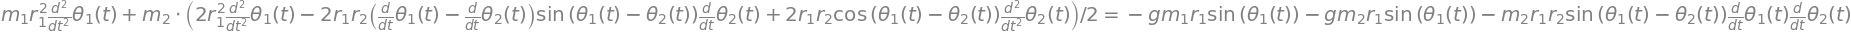

In [8]:
# 質点１の運動方程式
EOM_1 = sy.Eq(L.diff(theta1.diff(t)).diff(t), L.diff(theta1)) 
EOM_1

質点2 に対応する運動方程式は、二つ目のラグランジュ方程式から導出できます。

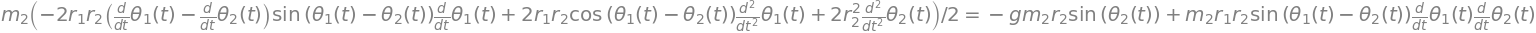

In [9]:
# 質点２の運動方程式
EOM_2 = sy.Eq(L.diff(theta2.diff(t)).diff(t), L.diff(theta2)) 
EOM_2

運動方程式は、連立２階微分方程式となっています。

今回の微分方程式は、線形であり、数値的には簡単に解けるものです。

質点の（角度の）加速度 $\ddot{\theta_1}, \ddot{\theta_2}$について解き、数値計算しやすい形に表します。

$$\ddot{\theta_1} = f_1 (\theta_1, \dot{\theta_1}, \theta_2, \dot{\theta_2})$$
$$\ddot{\theta_2} = f_2 (\theta_1, \dot{\theta_1}, \theta_2, \dot{\theta_2})$$

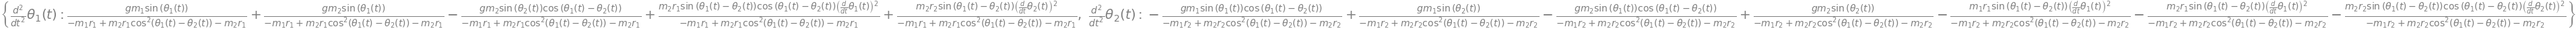

In [10]:
EOMs = sy.solve([EOM_1, EOM_2], (theta1.diff(t, 2), theta2.diff(t, 2)))
EOMs

In [11]:
# 関数を変数に置き換える
t1, t2 = sy.symbols(r"\theta_1 \theta_2")
diff2dot = [(theta1.diff(t), theta1_dot),
            (theta2.diff(t), theta2_dot)]
theta1_ddot = EOMs[theta1.diff(t, 2)].subs(diff2dot).subs([(theta1, t1), (theta2, t2)])
theta2_ddot = EOMs[theta2.diff(t, 2)].subs(diff2dot).subs([(theta1, t1), (theta2, t2)])

## 質点1の微分方程式
$$\ddot{\theta_1} = f_1 (\theta_1, \dot{\theta_1}, \theta_2, \dot{\theta_2})$$

は次のような関数となります。

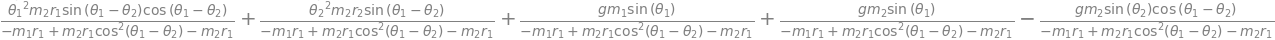

In [12]:
theta1_ddot

## 質点2の微分方程式
$$\ddot{\theta_2} = f_2 (\theta_1, \dot{\theta_1}, \theta_2, \dot{\theta_2})$$

は次のような関数となります。

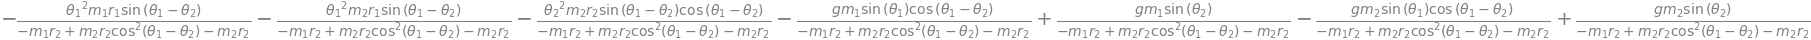

In [13]:
theta2_ddot

$t$ についての微分方程式を数値的に解くため、 $f_1, f_2$ を NumPy 関数に変換します。

In [14]:
# NumPyの関数に変換する
args = (t1, t2, theta1_dot, theta2_dot, m1, m2, r1, r2, g)
func1 = sy.lambdify(args, theta1_ddot, "numpy")
func2 = sy.lambdify(args, theta2_ddot, "numpy")

## 数値計算

scipy の `ode` ソルバーを使って常微分方程式を解いてみます。

（解析的に解いてから数値計算をしていますが、陰関数のまま数値計算を行い、数値計算時にタイムステップごとに逆行列を求める方法もあると思います。興味ある人は試してみてください）

In [15]:
# 数値計算
from scipy.integrate import ode

def time_evolve(t, y, params):
    theta1, theta2, theta1_dot, theta2_dot = y
    return [theta1_dot, theta2_dot,
            func1(*y, *params),
            func2(*y, *params)]

y0 = [np.pi * 1.01, np.pi * 1.01, 0, 0]
params = {"m1": 1, "m2": 1, "r1": 0.1, "r2": 0.1, "g": 9.8}
solver = ode(time_evolve).set_initial_value(y0, 0).set_f_params(params.values())

dt = 0.01
tmax = 100
results = []
while solver.t < tmax:
    y = solver.integrate(solver.t + dt)
    results.append([solver.t, *y])

In [16]:
import pandas as pd
results = pd.DataFrame(results, columns=["t", "theta1", "theta2", "theta1_dot", "theta2_dot"])
results["x1"] = params["r1"] * np.sin(results.theta1)
results["x2"] = results.x1 + params["r2"] * np.sin(results.theta2)
results["y1"] = -params["r1"] * np.cos(results.theta1)
results["y2"] = results.y1 - params["r2"] * np.cos(results.theta2)

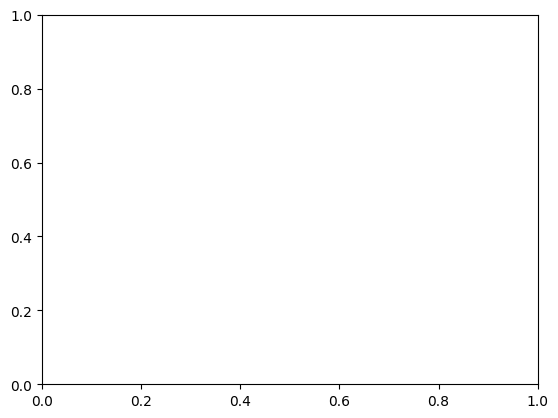

In [17]:
import matplotlib.animation as animation
import matplotlib.patches as patches

def gen():
    for i, vals in results[["t", "x1", "x2", "y1", "y2"]].iterrows():
        yield vals.values

def plot_double_pendulum(data):
    t, x1, x2, y1, y2 = data
    ax.cla()
    R = params["r1"] + params["r2"]
    ax.set_xlim(-R, R)
    ax.set_ylim(-R, R)
    ax.scatter([x1, x2], [y1, y2])
    ax.add_patch(patches.Arrow(0, 0, x1, y1, width=0.01))
    ax.add_patch(patches.Arrow(x1, y1, (x2-x1), (y2-y1), width=0.01))
    ax.set_aspect("equal")
fig, ax = plt.subplots()
ani = animation.FuncAnimation(fig, plot_double_pendulum, gen, interval=30, save_count=500)
# ani.save("double_pendulum.gif", writer="imagemagick", dpi=100)
# この辺は、 Jupyter Notebook でやるより、スクリプトで実行したほうが扱いやすい気がする... のでご注意
plt.show()

## 結果

いい感じに二重振り子のアニメーションが作れました。（長めバージョン）

<img src="double_pendulum.gif">

### まとめると
一つのセルにまとめると以下のように書けます。

In [18]:
# 変数と関数を定義
t = sy.Symbol("t", real=True)
r1, r2, m1, m2, g = sy.symbols(r"r_1 r_2 m_1 m_2 g", positive=True)
# theta1, theta2 = sy.symbols(r"\theta_1 \theta_2", real=True)
theta1 = sy.Function(r"\theta_1")(t)
theta2 = sy.Function(r"\theta_2")(t)
theta1_dot, theta2_dot = sy.symbols(r"\dot{\theta_1} \dot{\theta_2}")

# 質点１の位置と速度
x1 = sy.Matrix([r1 * sy.sin(theta1), - r1 * sy.cos(theta1)])
v1 = x1.diff(t)

# 質点２の位置と速度
x2 = x1 + sy.Matrix([r2 * sy.sin(theta2), - r2 * sy.cos(theta2)])
v2 = x2.diff(t)

# 運動エネルギー
T1 = (m1 * (v1[0]**2 + v1[1]**2) / 2).simplify()
T2 = (m2 * (v2[0]**2 + v2[1]**2) / 2).simplify()

# ポテンシャル
V1 = m1 * g * x1[1]
V2 = m2 * g * x2[1]

# ラグランジアン
L = T1 + T2 - V1 - V2

# 質点１、２の運動方程式
EOM_1 = sy.Eq(L.diff(theta1.diff(t)).diff(t), L.diff(theta1)) 
EOM_2 = sy.Eq(L.diff(theta2.diff(t)).diff(t), L.diff(theta2)) 

# 加速度について解く
EOMs = sy.solve([EOM_1, EOM_2], (theta1.diff(t, 2), theta2.diff(t, 2)))

# 関数を変数に変換
t1, t2 = sy.symbols(r"\theta_1 \theta_2")
diff2dot = [(theta1.diff(t), theta1_dot),
            (theta2.diff(t), theta2_dot)]
theta1_ddot = EOMs[theta1.diff(t, 2)].subs(diff2dot).subs([(theta1, t1), (theta2, t2)])
theta2_ddot = EOMs[theta2.diff(t, 2)].subs(diff2dot).subs([(theta1, t1), (theta2, t2)])

# NumPy関数化
args = (t1, t2, theta1_dot, theta2_dot, m1, m2, r1, r2, g)
func1 = sy.lambdify(args, theta1_ddot, "numpy")
func2 = sy.lambdify(args, theta2_ddot, "numpy")

# 数値計算
from scipy.integrate import ode

def time_evolve(t, y, params):
    theta1, theta2, theta1_dot, theta2_dot = y
    return [theta1_dot, theta2_dot,
            func1(*y, *params),
            func2(*y, *params)]

# 初期値
y0 = [np.pi * 1.01, np.pi * 1.01, 0, 0]
params = {"m1": 1, "m2": 1, "r1": 0.1, "r2": 0.1, "g": 9.8}
solver = ode(time_evolve).set_initial_value(y0, 0).set_f_params(params.values())

dt = 0.1
tmax = 50
results = []
while solver.t < tmax:
    y = solver.integrate(solver.t + dt)
    results.append([solver.t, *y])

import pandas as pd
results = pd.DataFrame(results, columns=["t", "theta1", "theta2", "theta1_dot", "theta2_dot"])
results["x1"] = params["r1"] * np.sin(results.theta1)
results["x2"] = results.x1 + params["r2"] * np.sin(results.theta2)
results["y1"] = -params["r1"] * np.cos(results.theta1)
results["y2"] = results.y1 - params["r2"] * np.cos(results.theta2)